# Reinforcement Learning in OpenAI

First, let's make sure we have the required modules installed, by running the following cell:

In [56]:
!pip install gym
!pip install tensorflow
!pip install keras

  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)


Now lets import the modules:

In [1]:
import gym
import math
import random
import time
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

Now, let's see how we can interact with the environment in OpenAI:

In [2]:
env_name = 'CartPole-v0'
env = gym.make(env_name)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(4,)
Action space: Discrete(2)


In OpenAI environments, the input we give our agents is taken from the Observation space. In this case, Box(4,) refers to a continuous space.
If we go to the CartPole-v1 documentation:(https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) 
we can see the observation space gives us 4 continuous observation (input) options, and 2 discrete action (output) options. 

Now let's see how we can make a basic agent:

In [3]:
class RandomAgent():
    # create basicAgent class
    def __init__(self,env):
        # constructor
        self.action_size = env.action_space.n
        # number of available actions, in this case 2
        
    def get_action(self,state):
        # method for choosing action
        action = random.choice(range(self.action_size))
        # choose random action 
        return action    

Now that we have a basic agent that returns a random action, lets run it:

In [4]:
agent = RandomAgent(env)
# create agent object
state = env.reset() 
# reset environment state and define initial state
total_reward = 0

for _ in range(100):
    # loop for 100 iterations
    action = agent.get_action(state)
    # get action from agent passing in the state
    state, reward, done, info = env.step(action)
    # returns the state after action (env object)
    # env.render()
    # time.sleep(0.03)
    if not done:
        total_reward += reward
env.close()
print("Reward: {}".format(total_reward))

Reward: 26.0


C:\Users\surface\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Each environment has its own "Solved" requirements, and some remain unsolved, as can be seen on the Leaderboard: https://github.com/openai/gym/wiki/Leaderboard
For the CartPole-v1 env, "done" returns True when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center, and "solving" is defined as getting average reward of 195.0 over 100 consecutive trials.  A reward of +1 is provided for every timestep that the pole remains upright. Done also returns true when the reward is 200. 

Obviously, our random agent isn't performing that well. Let's try and improve on this by giving it a non-random policy and interacting with the observation space:

In [5]:
class BasicPolicyAgent():
    def __init__(self,env):
        self.action_size = env.action_space.n
    def get_action(self, state):
        pole_angle = state[2]
        # index[2] of observation space
        action = 0 if pole_angle < 0 else 1
        # policy action, move left is angle < 0 else right
        return action

In [6]:
agent = BasicPolicyAgent(env)
state = env.reset()

total_reward = 0

for _ in range(100):
    action = agent.get_action(state)
    state, reward, done, info = env.step(action)
    # env.render()
    # time.sleep(0.03)
    if not done:
        total_reward += reward
env.close()
print("Reward: {}".format(total_reward))

Reward: 61.0


We can see that even with a very simple policy, the behavior is improved. Now we've seen how to interact with the environment and create agents.

Let's look at a simple implementation of the HillClimbing method. 
Essentially, we want a function that takes all the inputs (observations) available and outputs a vector with the predicted values of the next state of the environment based on a given action.

Essentially we want to transform our input state vector [1 4] to a [1 2] output action vector. We do this by multiplying the [1 4] matrix with a  [4 2] weights matrix. 

This weights matrix is initialized with random weights. We use this initial weights matrix to get our action (output) vector from our observation (input) vector. We calculate the total reward from the episode, and save it as our best reward. We also save the weights matrix as our best weights. We then sample a new random weights matrix, to which we add a random noise matrix of the same dimensions for variance. If the new total reward is higher than the best total reward, we use the weights that gave us this new higher reward and save them as best weights, and halve the noise matrix to decrease variance. If the new total reward is lower, we keep the old weights and double the noise matrix:

In [7]:
class HillClimbingAgent():
    def __init__(self, env):
        self.state_dim = env.observation_space.shape
        # shape or dimension of the env's observation_shape matrix
        self.action_size = env.action_space.n
        self.build_model()
        
    def build_model(self):
            self.weights = 1e-4*np.random.rand(*self.state_dim, self.action_size)
            # initialize random weights matrix
            self.best_reward = -np.Inf
            # initialize reward as lowest possible number
            self.best_weights = np.copy(self.weights)
            # initialize best_weights as first random weights matrix
            self.noise_scale = 1e-2
            # initialize noise scale
            
        
    def get_action(self, state):
            p = np.dot(state, self.weights)
            # dot product of state and weights
            action = np.argmax(p)
            # action is highest element in p
            return action
        
    def update_model(self, reward):
            if reward >= self.best_reward:
                self.best_reward = reward
                self.best_weights = np.copy(self.weights)
                self.noise_scale = max(self.noise_scale/2, 1e-3)
            else:
                self.noise_scale = min(self.noise_scale*2, 2)
                    
            self.weights = self.best_weights + self.noise_scale * np.random.rand(*self.state_dim, self.action_size)
            # sample new current weights by adding best weight and noise matrix scaled by new noise scale
            

Run 0
Episode: 0, total_reward: 10.00
Episode: 1, total_reward: 10.00
Episode: 2, total_reward: 10.00
Episode: 3, total_reward: 10.00
Episode: 4, total_reward: 9.00
Episode: 5, total_reward: 10.00
Episode: 6, total_reward: 10.00
Episode: 7, total_reward: 10.00
Episode: 8, total_reward: 9.00
Episode: 9, total_reward: 10.00
Episode: 10, total_reward: 10.00
Episode: 11, total_reward: 9.00
Episode: 12, total_reward: 9.00
Episode: 13, total_reward: 10.00
Episode: 14, total_reward: 8.00
Episode: 15, total_reward: 39.00
Episode: 16, total_reward: 32.00
Episode: 17, total_reward: 97.00
Episode: 18, total_reward: 70.00
Episode: 19, total_reward: 29.00
Episode: 20, total_reward: 49.00
Episode: 21, total_reward: 66.00
Episode: 22, total_reward: 10.00
Episode: 23, total_reward: 118.00
Episode: 24, total_reward: 9.00
Episode: 25, total_reward: 69.00
Episode: 26, total_reward: 96.00
Episode: 27, total_reward: 200.00
Episode: 28, total_reward: 117.00
Episode: 29, total_reward: 36.00
Episode: 30, tota

Text(0, 0.5, 'Average Reward')

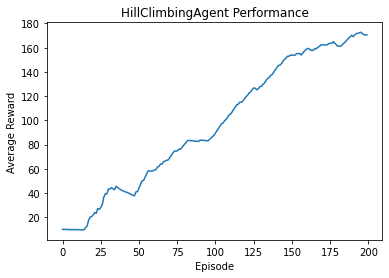

In [9]:
env_name = 'CartPole-v0'
env = gym.make(env_name)
num_runs = 1
run_rewards = []

for n in range(num_runs):
  print("Run {}".format(n))
  ep_rewards = []
  agent = HillClimbingAgent(env)
  num_episodes = 200

  for ep in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
      action = agent.get_action(state)
      state, reward, done, info = env.step(action)
      # env.render()
      total_reward += reward
      # time.sleep(0.03)

    ep_rewards.append(total_reward)
    agent.update_model(total_reward)
    print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
run_rewards.append(ep_rewards)
env.close()

for n, ep_rewards in enumerate(run_rewards):
  x = range(len(ep_rewards))
  cumsum = np.cumsum(ep_rewards)
  avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
  plt.plot(x, avgs)
plt.title("HillClimbingAgent Performance")
plt.xlabel("Episode")
plt.ylabel("Average Reward")


After just 200 episodes, we can see that the agent is now able to keep the pole upright for the maximum 200 frames consistently (depending on how lucky you are with the random initialized weights matrix, this may take more episodes). 

Let's try this method in a different gym environment. The acrobot system includes two joints and two links, where the joint between the two links is actuated. Initially, the links are hanging downwards, and the goal is to swing the end of the lower link up to a given height. The action is either applying +1, 0 or -1 torque on the joint between the two pendulum links. The Observation space or state consists of the sin() and cos() of the two rotational joint angles and the joint angular velocities.

Run 0
Episode: 0, total_reward: -500.00
Episode: 1, total_reward: -500.00
Episode: 2, total_reward: -500.00
Episode: 3, total_reward: -500.00
Episode: 4, total_reward: -500.00
Episode: 5, total_reward: -500.00
Episode: 6, total_reward: -500.00
Episode: 7, total_reward: -500.00
Episode: 8, total_reward: -500.00
Episode: 9, total_reward: -500.00
Episode: 10, total_reward: -500.00
Episode: 11, total_reward: -500.00
Episode: 12, total_reward: -500.00
Episode: 13, total_reward: -500.00
Episode: 14, total_reward: -500.00
Episode: 15, total_reward: -500.00
Episode: 16, total_reward: -500.00
Episode: 17, total_reward: -500.00
Episode: 18, total_reward: -500.00
Episode: 19, total_reward: -500.00
Episode: 20, total_reward: -500.00
Episode: 21, total_reward: -500.00
Episode: 22, total_reward: -500.00
Episode: 23, total_reward: -361.00
Episode: 24, total_reward: -320.00
Episode: 25, total_reward: -500.00
Episode: 26, total_reward: -500.00
Episode: 27, total_reward: -500.00
Episode: 28, total_rewar

Text(0, 0.5, 'Average Reward')

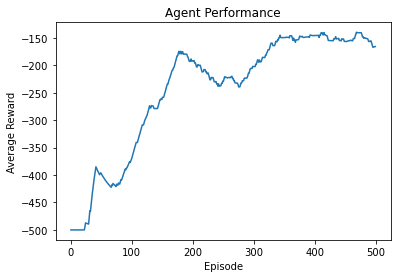

In [10]:
env_name = "Acrobot-v1"
env = gym.make(env_name)
num_runs = 1
run_rewards = []

for n in range(num_runs):
  print("Run {}".format(n))
  ep_rewards = []
  agent = HillClimbingAgent(env)
  num_episodes = 500

  for ep in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
      action = agent.get_action(state)
      state, reward, done, info = env.step(action)
      # env.render()
      total_reward += reward
      # time.sleep(0.03)

    ep_rewards.append(total_reward)
    agent.update_model(total_reward)
    print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
run_rewards.append(ep_rewards)
env.close()

for n, ep_rewards in enumerate(run_rewards):
  x = range(len(ep_rewards))
  cumsum = np.cumsum(ep_rewards)
  avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
  plt.plot(x, avgs)
plt.title("Agent Performance")
plt.xlabel("Episode")
plt.ylabel("Average Reward")

We can see here that the HillClimbing method does not work as well in this environment as it did for the CartPole environment. Looking at the CartPole environment, this method sometimes lead to a high reward, and in a subsequent run a lower reward. Note that sampling the weights matrix never saves the individual best weights for each matrix, essentially each action-state -> reward combination isn't individually saved but rather the entire weights matrix. We'll revisit this later.



Now let's try our HillClimbingAgent in the MountainCar-v0 environment. The goal is to get the car to the top of the mountain. A reward of -1 is given each timestep, and a reward of 0 is given when the goal is reached.

Observation space: state[0] = car xpos; state[1] = car velocity |
Action space: action[0] = push left; action[1] = no push; action[2] = push right

Run 0
Episode: 0, total_reward: -200.00
Episode: 1, total_reward: -200.00
Episode: 2, total_reward: -200.00
Episode: 3, total_reward: -200.00
Episode: 4, total_reward: -200.00
Episode: 5, total_reward: -200.00
Episode: 6, total_reward: -200.00
Episode: 7, total_reward: -200.00
Episode: 8, total_reward: -200.00
Episode: 9, total_reward: -200.00
Episode: 10, total_reward: -200.00
Episode: 11, total_reward: -200.00
Episode: 12, total_reward: -200.00
Episode: 13, total_reward: -200.00
Episode: 14, total_reward: -200.00
Episode: 15, total_reward: -200.00
Episode: 16, total_reward: -200.00
Episode: 17, total_reward: -200.00
Episode: 18, total_reward: -200.00
Episode: 19, total_reward: -200.00
Episode: 20, total_reward: -200.00
Episode: 21, total_reward: -200.00
Episode: 22, total_reward: -200.00
Episode: 23, total_reward: -200.00
Episode: 24, total_reward: -200.00
Episode: 25, total_reward: -200.00
Episode: 26, total_reward: -200.00
Episode: 27, total_reward: -200.00
Episode: 28, total_rewar

Text(0, 0.5, 'Average Reward')

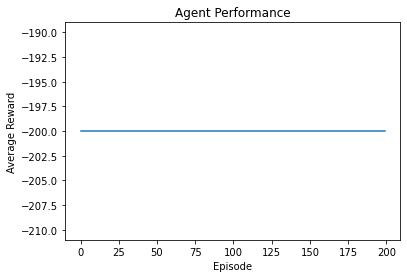

In [11]:
env_name = "MountainCar-v0"
env = gym.make(env_name)
num_runs = 1
run_rewards = []

for n in range(num_runs):
  print("Run {}".format(n))
  ep_rewards = []
  agent = HillClimbingAgent(env)
  num_episodes = 200

  for ep in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
      action = agent.get_action(state)
      state, reward, done, info = env.step(action)
      # env.render()
      total_reward += reward
      # time.sleep(0.03)

    ep_rewards.append(total_reward)
    agent.update_model(total_reward)
    print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
run_rewards.append(ep_rewards)
env.close()

for n, ep_rewards in enumerate(run_rewards):
  x = range(len(ep_rewards))
  cumsum = np.cumsum(ep_rewards)
  avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
  plt.plot(x, avgs)
plt.title("Agent Performance")
plt.xlabel("Episode")
plt.ylabel("Average Reward")


One of the reasons the MountainCar-v0 env is harder than the CartPole env is that the goal state is not easily reached randomly, as the car motor does not have enough power by itself to get to the goal, whereas with the CartPole the goal state is the initial state. Due to the nature of the reward in this env, this means the HillClimbing agent rarely if ever reaches a better reward, as it is exploring actions randomly and there is no incremental reward. Over time the increasing variance of the added noise may lead to to improved rewards but it can take a long time.

Now let's introduce Q-Learning; it is a reinforcement learning algorithm that aims to find the best action to take given a current state to maximize reward. This algorithm is considered off-policy due to the fact the Q-learning function learns from actions outside the current policy, like taking random actions. 

The first step is to create a Q-table (or matrix) that follows the shape of [state, action] and we initialize each value in the matrix to zero. We update and store our Q-values in this matrix after each episode. This then becomes a reference table for our agent to select the best action based on the highest Q-value. 

The second step is to interact with the environment, and update the state-action pairs in our Q-table. This is done in one of two ways: exploiting, or exploring. When exploiting, the Q-table is used as reference to view all possible actions for a given state, and the agent selects the action based on the max value of said action. When exploring, the action is taken randomly. This is important as it allows the agent to explore and discover new states that may not be selected during exploitation. These two modes of interaction with the environment are balanced using a variable usually named epsilon, which determines the probability of exploring versus exploiting. 

We've mentioned epsilon (exploration probability), one of the hyperparameters, there are others that are useful. The learning rate, sometimes denoted alpha, is how much an updated value is "accepted" vs the old one. The difference between the new and old value is multiplied by this learning rate and added to the previous q-value. A discount factor, usually denoted gamma, can be used to balance immediate and future reward.

In [51]:
class QAgent():
    def __init__(self, env, buckets=(3, 3, 6, 6,), min_alpha=0.1, min_epsilon=0.1, gamma=1.0, ada_divisor=20):
        self.env = env # for choosing different environments
        self.buckets = buckets # down-scaling feature space to discrete range
        self.min_alpha = min_alpha # learning rate
        self.min_epsilon = min_epsilon # exploration rate
        self.gamma = gamma # discount factor
        self.ada_divisor = ada_divisor # decay rate parameter for alpha and epsilon

        # initialising Q-table
        self.Q = np.zeros(self.buckets + (self.env.action_space.n,))

    # Discretizing input space to make Q-table and to reduce dimmensionality
    def discretize(self, state):
        upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50)]
        lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50)]
        ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
        discretized_state = [int(round((self.buckets[i] - 1) * ratios[i])) for i in range(len(state))]
        discretized_state = [min(self.buckets[i] - 1, max(0, discretized_state[i])) for i in range(len(state))]
        return tuple(discretized_state)

    # Choosing action based on epsilon-greedy policy
    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.Q[state])

    # Updating Q-value of state-action pair based on the Bellman equation
    def update_q(self, state, action, reward, next_state, alpha):
        self.Q[state][action] += alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])

    # Reduce Exploration Rate Over time
    def get_epsilon(self, t):
        return max(self.min_epsilon, min(1, 1.0 - math.log10((t + 1) / self.ada_divisor)))

    # Reduce Learning Rate over time
    def get_alpha(self, t):
        return max(self.min_alpha, min(1.0, 1.0 - math.log10((t + 1) / self.ada_divisor)))




Run 0
Episode: 0, total_reward: 30.00
Episode: 1, total_reward: 20.00
Episode: 2, total_reward: 27.00
Episode: 3, total_reward: 16.00
Episode: 4, total_reward: 53.00
Episode: 5, total_reward: 18.00
Episode: 6, total_reward: 33.00
Episode: 7, total_reward: 25.00
Episode: 8, total_reward: 18.00
Episode: 9, total_reward: 15.00
Episode: 10, total_reward: 22.00
Episode: 11, total_reward: 17.00
Episode: 12, total_reward: 44.00
Episode: 13, total_reward: 42.00
Episode: 14, total_reward: 20.00
Episode: 15, total_reward: 19.00
Episode: 16, total_reward: 19.00
Episode: 17, total_reward: 32.00
Episode: 18, total_reward: 11.00
Episode: 19, total_reward: 31.00
Episode: 20, total_reward: 26.00
Episode: 21, total_reward: 27.00
Episode: 22, total_reward: 27.00
Episode: 23, total_reward: 17.00
Episode: 24, total_reward: 25.00
Episode: 25, total_reward: 14.00
Episode: 26, total_reward: 12.00
Episode: 27, total_reward: 40.00
Episode: 28, total_reward: 29.00
Episode: 29, total_reward: 20.00
Episode: 30, t

Text(0, 0.5, 'Average Reward')

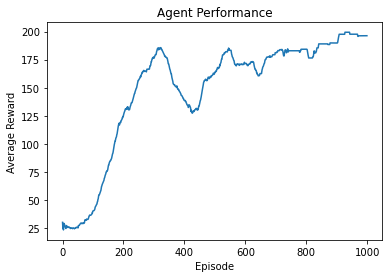

In [52]:
num_runs = 1
run_rewards = []
env = gym.make('CartPole-v0')

for n in range(num_runs):
  print("Run {}".format(n))
  ep_rewards = []
  num_episodes = 1000
  agent = QAgent(env)

  for ep in range(num_episodes):
    # As states are continuous, discretize them into buckets
    discretized_state = agent.discretize(env.reset())

    # Get adaptive learning alpha and epsilon decayed over time
    alpha = agent.get_alpha(ep)
    epsilon = agent.get_epsilon(ep)
            
    total_reward = 0
    done = False
    i = 0
    
    while not done:
        # Choose action according to greedy policy and take it
        action = agent.choose_action(discretized_state, epsilon)
        state, reward, done, info = env.step(action)
        next_state = agent.discretize(state)
        # Update Q-Table
        agent.update_q(discretized_state, action, reward, next_state, alpha)
        discretized_state = next_state
        i += 1
        # env.render()
        total_reward += reward
        # time.sleep(0.03)
    ep_rewards.append(total_reward)
    print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
run_rewards.append(ep_rewards)
env.close()

for n, ep_rewards in enumerate(run_rewards):
  x = range(len(ep_rewards))
  cumsum = np.cumsum(ep_rewards)
  avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
  plt.plot(x, avgs)
plt.title("Agent Performance")
plt.xlabel("Episode")
plt.ylabel("Average Reward")

In [ ]:
import keras
from keras.models import  Sequential
from keras.layers import Dense
from keras.optimizers import Adam

max_score = 0

n_win_tick = 1000
max_env_steps = 1000

#environment Parameters
memory = deque(maxlen=100000)
if max_env_steps is not None:
    env._max_episode_steps = max_env_steps
    
model = keras.Sequential()
model.add(Dense(24,input_dim=4,activation='relu'))
model.add(Dense(48, activation='relu'))
model.add(Dense(96, activation='relu'))
model.add(Dense(48, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(2,activation='relu'))
model.compile(loss='mse', optimizer=Adam(lr=0.01, decay=0.01))
    

class DQNAgent():
    def __init__(self, env, model, gamma = 1.0, epsilon = 1.0, epsilon_min = 0.01, 
                 epsilon_decay = 0.999, alpha = 0.01, alpha_decay = 0.01, 
                 alpha_test_factor = 1.0, batch_size = 256):
        self.env = env
        self.model = model
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.alpha_test_fact0r = alpha_test_factor
        self.batch_size = batch_size
        
        

    
        
        
        #Define functions
    def remember(self, state, action, reward, next_state, done):
        memory.append((state, action, reward, next_state, done))
    def choose_action(self, state, epsilon):
        if np.random.random() <= epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(model.predict(state))
    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon,1.0 - math.log10((t+1)*self.epsilon_decay)))
    def preprocess(self, state):
        return np.reshape(state, [1,4])
    def replay(self, batch_size,epsilon):
        x_batch, y_batch = [], []
        minibatch = random.sample(memory, min(len(memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = model.predict(state)
            y_target[0][action] = reward if done else reward + gamma * np.max(model.predict(next_state)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

In [ ]:
num_runs = 1
run_rewards = []
env = gym.make('CartPole-v0')

for n in range(num_runs):
    print("Run {}.format(n)")
    ep_rewards = []
    num_episodes = 1000
    agent = DQNAgent(env, model)
    
    for ep in range(num_episodes):
        if ep > num_episodes - 2:
            agent.epsilon = 0.0
        state = agent.preprocess(env.reset())
        done = False
        i = 0
        total_reward = 0
        
        
        
    while not done:
        action = agent.choose_action(state, agent.get_epsilon(ep))
        next_state, reward, done, info = env.step(action)
        # env.render()
        next_state = agent.preprocess(next_state)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        i += 1
        total_reward += reward
        # time.sleep(0.03)
    ep_rewards.append(total_reward)
    print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
run_rewards.append(ep_rewards)
env.close()
for n, ep_rewards in enumerate(run_rewards):
  x = range(len(ep_rewards))
  cumsum = np.cumsum(ep_rewards)
  avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
  plt.plot(x, avgs)
plt.title("Agent Performance")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
print(x)

        

In [63]:
import tensorflow.compat.v1 as tf

class QNAgent():
    def __init__(self, env, buckets=(3, 3, 6, 6,), min_alpha=0.1, min_epsilon=0.1, gamma=1.0, ada_divisor=20):
        self.env = env # for choosing different environments
        self.buckets = buckets # down-scaling feature space to discrete range
        self.min_alpha = min_alpha # learning rate
        self.min_epsilon = min_epsilon # exploration rate
        self.gamma = gamma # discount factor
        self.ada_divisor = ada_divisor # decay rate parameter for alpha and epsilon
        self.build_model()
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def build_model():
        tf.reset_default_graph()
        tf.disable_v2_behavior()
        # since we named a TensorFlow variable, reset graph before we define a model or else TensorFlow complains about redefining variables with duplicate names
        self.state_in = tf.placeholder(tf.int32, shape = [1])
        self.action_in = tf.placeholder(tf.int32, shape = [1])
        self.target_in = tf.placeholder(tf.float32, shape = [1])
        # define placeholders for the state and action indices as the inputs
        # and the target value used to calculate loss
        self.state = tf.one_hot(self.state_in, depth = self.state_size)
        self.action = tf.one_hot(self.action_in, depth = self.action_size)
        # convert input state and action index values to one-hot vector adding 2nd dimension giving depth to placeholder shape
        self.q_state = tf.layers.dense(self.state, units = self.action_size, name = "q_table")
        # from state vector pass to dense layer which outputs the row of Qvalues for the actions in the given state
        # we name the tensor to find the weights in the TensorFlow backend since they are the same values as the Qtable we want to print
        self.q_action = tf.reduce_sum(tf.multiply(self.q_state, self.action), axis = 1)
        # get Qvalue of given action through element-wise multiplication of the Qvalues with the one-hot action vector 
        # reduce it back to a single dimension vector
        self.loss = tf.reduce_sum(tf.square(self.target_in - self.q_action))
        # calculate loss as square diff of target and aprox Qvalue for the state-action pair, summed over the batch
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        # optimizer to minimize loss at the specified learning rate
        
    # Discretizing input space to make Q-table and to reduce dimmensionality
    def discretize(self, state):
        upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50)]
        lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50)]
        ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
        discretized_state = [int(round((self.buckets[i] - 1) * ratios[i])) for i in range(len(state))]
        discretized_state = [min(self.buckets[i] - 1, max(0, discretized_state[i])) for i in range(len(state))]
        return tuple(discretized_state)

    # Choosing action based on epsilon-greedy policy
    def choose_action(self, state, epsilon):
        q_state = self.sess.run(self.q_state, feed_dict = {self.state_in: [state]})
        # calculate state Qvalues by running the Q state operation by passing in the given state as a single element list to comply with our specified shape in the placeholder
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(q_state)

    # Updating Q-value of state-action pair based on the Bellman equation
    def update_q(self, state, action, reward, next_state, alpha):
        self.Q[state][action] += alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])

    # Reduce Exploration Rate Over time
    def get_epsilon(self, t):
        return max(self.min_epsilon, min(1, 1.0 - math.log10((t + 1) / self.ada_divisor)))

    # Reduce Learning Rate over time
    def get_alpha(self, t):
        return max(self.min_alpha, min(1.0, 1.0 - math.log10((t + 1) / self.ada_divisor)))

    def train(self, experience):
        # define train method for updating Qtable at each step
        state, action, next_state, reward, done = ([exp] for exp in experience)
        # takes the tuple of experience # NN implementation: wrap each value from the tuple in a list to comply with specified placeholder
        q_next = self.sess.run(self.q_state, feed_dict = {self.state_in: next_state})
        # calculate the next state's Qvalues
        q_next[done] = np.zeros([self.action_size]) # if done else q_next # non NN implementation
        # only non-terminal states have a next state so set Qvalues to 0 if next state is terminal
        # use list form [done] to set the value in the q_next list to zeros at the index where done is true
        q_target = reward + self.discount_rate * np.max(q_next)
        # calculate target value according to QLearning equation
        feed = {self.state_in: state, self.action_in: action, self.target_in: q_target}
        self.sess.run(self.optimizer, feed_dict = feed)
        # run optimizer passing in state action and target into the feed dictionary

    def __del__(self):
        # destructor
        self.sess.close()
        # close TensorFlow session


        

In [35]:
agent = QNAgent(env)
total_reward = 0
# to keep track of cumulative reward
for ep in range(100):
    # train over a number of episodes
    state = env.reset() 
    done = False
    while not done:  

        action = agent.get_action(state) 
        # call get_action() on agent; pass state as argument
        next_state, reward, done, info = env.step(action) 
        # apply action to environment; 
        # env.step() returns a tuple (list) with the next state, reward for last step, boolean for terminal episode, and info
        # episode termination conditions can be found in docu
        agent.train((state,action,next_state,reward,done))
        # call train method from agent passing the 5 values
        state = next_state
        # update state
        total_reward += reward
        # add reward 
        # env.render() 
        # render environment
        print("s:", state, 'a:', action)
        print("Episode {}, Total reward: {}, eps: {}".format(ep, total_reward, agent.eps))
        
        with tf.variable_scope("q_table", reuse = True):
        # activate the variable scope "q_table", reuse=True to include existing variables
            weights = agent.sess.run(tf.get_variable("kernel"))
            # get weight matrix from TensorFlow session (which is our q_table)
            print(weights)
          
        # print(agent.q_table) # non NN implementation
        # print Qtable for debugging
        # time.sleep(0.05) 
        # slows down env.render() to prevent crash
        clear_output(wait=True)
    env.close() 
    # close env after forloop ends to prevent crash with some gyms
    

 

TypeError: build_model() takes 0 positional arguments but 1 was given

In [ ]:

  
import gym
import math
import keras
import random
import numpy as np
from collections import deque
from  keras.models import  Sequential
from keras.layers import Dense
from keras.optimizers import Adam

max_score = 0

n_episodes = 5000
n_win_tick = 1000
max_env_steps = 1000

gamma = 1.0
epsilon = 1.0 #exploration
epsilon_min = 0.01
epsilon_decay = 0.999

alpha = 0.01 # learning rate
alpha_decay = 0.01
alpha_test_factor = 1.0

batch_size = 256
monitor = False
quiet = False

#environment Parameters
memory = deque(maxlen=100000)
env = gym.make('CartPole-v0')
if max_env_steps is not None:
    env._max_episode_steps = max_env_steps




# for i_episode in range(20):
#     observation = env.reset()
#     for t in range(100):
#         env.render()
#         action = env.action_space.sample()
#         observation, reward, done, info = env.step(action)
#         if done:
#             break


model = Sequential()
model.add(Dense(24,input_dim=4,activation='relu'))
model.add(Dense(48, activation='relu'))
model.add(Dense(96, activation='relu'))
model.add(Dense(48, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(2,activation='relu'))
model.compile(loss='mse', optimizer=Adam(lr=alpha, decay=alpha_decay))

#Define functions
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))
def choose_action(state, epsilon):
    if np.random.random() <= epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(model.predict(state))
def get_epsilon(t):
    return max(epsilon_min, min(epsilon,1.0 - math.log10((t+1)*epsilon_decay)))
def preprocess(state):
    return np.reshape(state, [1,4])
def replay(batch_size,epsilon):
    x_batch, y_batch = [], []
    minibatch = random.sample(memory, min(len(memory), batch_size))
    for state, action, reward, next_state, done in minibatch:
        y_target = model.predict(state)
        y_target[0][action] = reward if done else reward + gamma * np.max(model.predict(next_state)[0])
        x_batch.append(state[0])
        y_batch.append(y_target[0])
    model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
# run function
def run():
    global max_score
    scores = deque(maxlen=100)
    for e in range(n_episodes):
        if e > n_episodes-2:
            global epsilon
            epsilon = 0.0
        state = preprocess(env.reset())
        done = False
        i = 0
        while not done:
            action = choose_action(state, get_epsilon(e))
            next_state, reward, done, _ = env.step(action)
            # env.render()
            next_state = preprocess(next_state)
            remember(state, action, reward, next_state, done)
            state = next_state
            i += 1
        if i > max_score:
            max_score = i
            # Save the weights
            model.save_weights(str(max_score) + 'model_weights.h5')

            # Save the model architecture
            with open(str(max_score) + 'model_architecture.json', 'w') as f:
                f.write(model.to_json())


        scores.append(i)
        mean_score = np.mean(scores)
        if mean_score >= n_win_tick and e >= 100:
            if not quiet: print("Ran " + str(e) + " episodes. Solved after " + str(e-100) + "trials")
            # Save the weights
            model.save_weights(str(max_score) + 'final_model_weights.h5')

            # Save the model architecture
            with open(str(max_score) + 'final_model_architecture.json', 'w') as f:
                f.write(model.to_json())

            return e-100
        if e % 100 == 0 and not quiet:
            print("episode " + str(e) + " mean survival time over last 100 episodes was " + str(mean_score) + " ticks")
        replay(batch_size, get_epsilon(e))
    if not quiet:
        print("did not solve after " + str(e) + " episodes")
    return e

#Training the network

run()

print("max achived score is : " + str(max_score))





episode 0 mean survival time over last 100 episodes was 33.0 ticks


In [ ]:
class DQN:
    def __init__(self, model, env,
                 epsilon=0.5, epsilon_decay=0.995, epsilon_min=0.1,
                 gamma=0.995,
                 history_size=10000, epochs=10, train_size=10000, batch_size=256,
                 max_steps=5000,
                 log_every_n_steps=1,
                 evalutation_size=10,
                 target_score=500,
                 reward_func=None):
        """
        DQN - Reinforcement learning agent
        Parameters:
            model: model with fit() and predict() methods
            env: gym environment
            epsilon: probability of random actions
            epsilon_decay: decay of epsilon on the next training episode
            epsilon_min: minimum value of epsilon
            gamma: discount for the next state
            history_size: total number of stored observations among all episodes
            epochs: number of training epochs per episode
            train_size: number of obervations to train on after each episode
            batch_size: batch size for fit() method of the model
            max_steps: maximum number of steps in episode
            log_every_n_steps: output metrics every n steps
            evalutation_size: number of episodes in evaluations
            target_score: target score to finish when reached
            reward_func: function that transforms observations to rewards; use None for model-free RL
        """

        self.model = model
        self.env = env
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.history_size = history_size
        self.epochs = epochs
        self.train_size = train_size
        self.batch_size = batch_size
        self.max_steps = max_steps
        self.log_every_n_steps = log_every_n_steps
        self.evalutation_size = evalutation_size
        self.target_score = target_score
        self.reward_func = reward_func

        self._epsilon = self.epsilon  # current epsilon
        self.history = deque(maxlen=self.history_size)
        self.scores = list()  # list of scores for each played episode

        assert self.model, "Model is not provided"
        model_methods = ("fit", "predict")
        for method_name in model_methods:
            assert callable(getattr(self.model, method_name, None)), "Invalid model: no %s() method" % method_name

        assert self.env, "Gym environment is not provided"
        model_methods = ("reset", "step", "render")
        for method_name in model_methods:
            assert callable(getattr(self.env, method_name, None)), "Invalid env: no %s() method" % method_name

        self.n_inputs = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.n

        # columns offsets in a numpy row (see fit_one())
        self.STATE_idx = 0  # observation
        self.NEXT_STATE_idx = self.n_inputs  # next observation
        self.ACTION_idx = 2 * self.n_inputs
        self.DONE_idx = 2 * self.n_inputs + 1
        self.R_idx = 2 * self.n_inputs + 2
        self.MAXQ_idx = 2 * self.n_inputs + 3

    def get_action(self, observation):
        """
        Policy function: returns action for the given observation
        """

        return np.argmax(self.model.predict(observation.reshape(1,-1))[0])


    def fit_one(self):
        """
        Train the model on a single episode
        """

        score = 0
        observation = self.env.reset()
        done = False

        for _ in range(self.max_steps):
            if random.random() < self._epsilon:
                # explore - take random action
                action = self.env.action_space.sample()
            else:
                # exploit - take predicted action
                action = self.get_action(observation)

            next_observation, reward, done, info = self.env.step(action)

            if self.reward_func:  # redefine reward if reward_func is set
                reward_ = self.reward_func(next_observation)
            else:
                reward_ = reward

            # append row for further training
            self.history.append(list(observation) + list(next_observation) + \
                [action, done, reward_, 0] + [0] * self.n_actions)

            score += reward
            if done:
                break
            observation = next_observation

        # append last episode score to list of scores
        self.scores.append(score)

        # prepare training data:
        data = np.array(random.sample(self.history, min(self.train_size, len(self.history))))

        # predict max(Q'):
        data[:, self.MAXQ_idx] = np.max(self.model.predict(data[:, self.NEXT_STATE_idx:self.NEXT_STATE_idx+self.n_inputs]), axis=1)

        # predict Q:
        data[:, -self.n_actions:] = self.model.predict(data[:, :self.n_inputs])

        for i in range(self.n_actions):
            # Q(s,a) = r + gamma * max(Q(s',a'))
            data[data[:, self.ACTION_idx] == i, -self.n_actions+i] = \
                data[data[:, self.ACTION_idx] == i, self.R_idx] + \
                self.gamma * data[data[:, self.ACTION_idx] == i, self.MAXQ_idx]

            # set Q(s,a) to 1 if done:
            data[(data[:, self.DONE_idx] == 1) & (data[:, self.ACTION_idx] == i), -self.n_actions + i] = 1

        self.model.fit(
            data[:, :self.n_inputs],
            data[:, -self.n_actions:],
            batch_size=self.batch_size,
            epochs=10,
            verbose=0)
        self._epsilon = max(self.epsilon_min, self._epsilon*self.epsilon_decay)

    def fit(self, episodes=2000):
        """
        Fit the model
        """

        for i in range(1, episodes + 1):
            self.fit_one()
            
            if i % self.log_every_n_steps==0:
                score = self.evaluate()
                print("Episode %i/%i: avg. score=%.1f, epsilon=%.2f, history_size=%i, train_size=%i" % (
                    i, episodes, score, self._epsilon, len(self.history), min(self.train_size, len(self.history))))
                if score >= self.target_score:
                    print("Target score achieved: target=%.1f, actual=%.1f" % (self.target_score, score))
                    return

        print("Target score is not reached")

    def evaluate(self, render_games=1):
        """
        Evaluate the model's performance without random actions
        render_games: number of games withing evaluation_size to render on screen
        """

        scores = list()
        for _ in range(self.evalutation_size):
            score = 0
            observation = self.env.reset()

            for j in range(self.max_steps):
                if _ < render_games:  # render only `render_games` episodes
                    # self.env.render()
                    action = self.get_action(observation)
                next_observation, reward, done, info = self.env.step(action)
                score += reward
                if done: break
                observation = next_observation
            scores.append(score)
        return np.mean(scores)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

env = gym.make('CartPole-v1')
n_inputs = env.observation_space.shape[0]
n_actions = env.action_space.n
max_theta = env.observation_space.high[2]
def cartpole_reward(observation):
    return max_theta - abs(observation[2])

# create model
model = Sequential()
model.add(Dense(units=24, activation="tanh", input_dim=n_inputs))
model.add(Dense(units=24, activation="tanh"))
model.add(Dense(units=n_actions, activation="linear"))
model.compile(loss="mse", optimizer=Adam(lr=0.1, decay=0.03))
agent = DQN(model, env)
start = time.time()
agent.fit()
print("Elapsed time: %.1f seconds" % (time.time()-start))